In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import create_param_list

In [49]:
nconf = 31
ndata = 400
L = 64
T_cr = 2.269 # critical temp for 2d ising
t_start = 2.1

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Ising")
# print(prm_list)
print(f"データ数:{nconf*ndata}")

データ数:12400


In [50]:
img_list, temp_list, answer_list = [], [], []
for num in range(nconf):
    for iconf in range(ndata):
        file = f"{prm_list[num][1]}{iconf}.npy"
        img_list.append(np.load(file))
        temp_list.append(prm_list[num][0])
        if prm_list[num][0] < T_cr:
            answer = 0
        else:
            answer = 1
        answer_list.append(answer)

img_dataset = np.array(img_list)

In [51]:
def inference(prediction):
    xs, y1s, y2s = [], [], []
    sum_pred = 0
    count = 0

    for i in range(len(prediction)):
        if i == 0:
            sum_pred += prediction[i]
            count += 1
            xs.append(temp_list[i])
        else:
            if temp_list[i] != temp_list[i-1]:
                # y1s, y2sに格納
                prob = sum_pred/count
                y1s.append(1 - prob)
                y2s.append(prob)

                sum_pred = 0
                count = 0
                sum_pred += prediction[i]
                count += 1
                xs.append(temp_list[i])
            elif i == len(prediction)-1:
                # y1s, y2sに格納
                prob = sum_pred/count
                y1s.append(1 - prob)
                y2s.append(prob)
            else:
                sum_pred += prediction[i]
                count += 1
    return xs, y1s, y2s

[[-0.19032577 -0.23358781 -0.23719716 ... -0.2828978  -0.24075639
  -0.21098781]
 [ 0.07042327  0.08643084  0.08776636 ...  0.10467625  0.08908332
   0.07806852]]


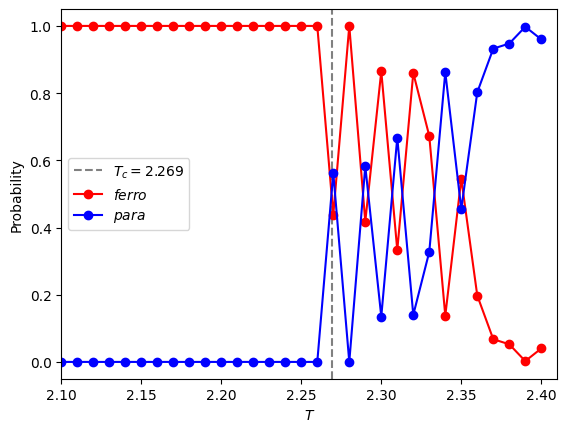

In [52]:
# flatten+kmeans
n_clusters = 2

img_dataset_flatten = img_dataset.reshape(img_dataset.shape[0], -1)
sc = StandardScaler()
img_dataset_std = sc.fit_transform(img_dataset_flatten)
model = KMeans(n_clusters=n_clusters, n_init='auto').fit(img_dataset_std)

prediction = list(model.labels_)  # クラスタのラベル
# print(prediction)
centers = model.cluster_centers_  # クラスタの重心
print(centers)

xs, y1s, y2s = inference(prediction)
plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr))
plt.xlim(t_start, t_end)
plt.plot(xs, y2s, label=r"$ferro$", marker="o", color="red")
plt.plot(xs, y1s, label=r"$para$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()

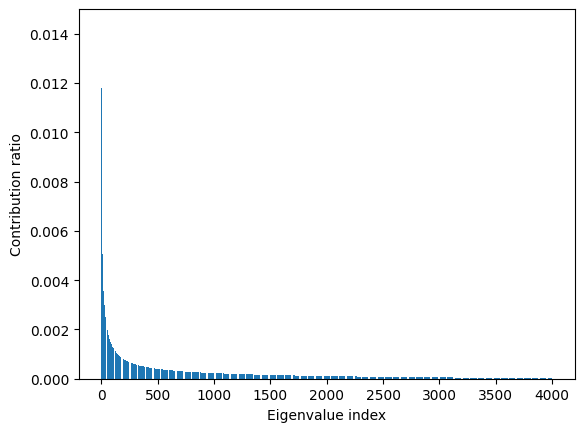

explained variance ratio 10.0% over
9
explained variance ratio 20.0% over
37
explained variance ratio 30.000000000000004% over
91
explained variance ratio 40.0% over
185
explained variance ratio 50.0% over
336
explained variance ratio 60.0% over
563
explained variance ratio 70.0% over
895
explained variance ratio 80.0% over
1384
explained variance ratio 89.99999999999999% over
2167


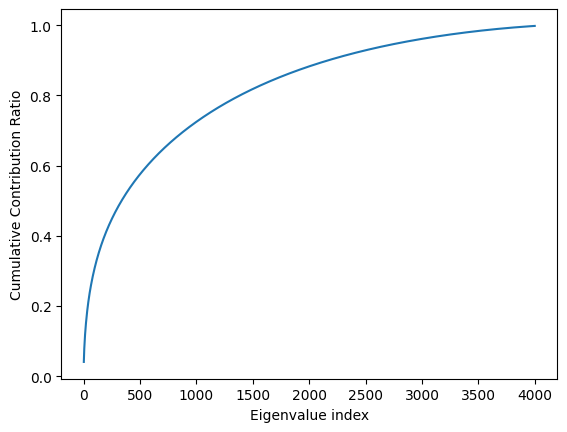

In [53]:
# 累積寄与率を決定する
n_components = 4000

img_dataset_flatten = img_dataset.reshape(img_dataset.shape[0], -1)
sc = StandardScaler()
img_dataset_std = sc.fit_transform(img_dataset_flatten)

pca = PCA(n_components=n_components)
pca.fit(img_dataset_std)
plt.ylim(0,0.015)
plt.xlabel("Eigenvalue index")
plt.ylabel("Contribution ratio")
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
plt.show()

total_ratio = 0
count = 0
prob = 0.10
ratio_list = []
for ratio in pca.explained_variance_ratio_:
    total_ratio += ratio
    count += 1
    ratio_list.append(total_ratio)
    if total_ratio > prob:
        print(f"explained variance ratio {prob*100}% over")
        print(count)
        prob += 0.10
plt.xlabel("Eigenvalue index")
plt.ylabel("Cumulative Contribution Ratio")
plt.plot([n for n in range(1, len(pca.explained_variance_ratio_)+1)], ratio_list)
plt.show()

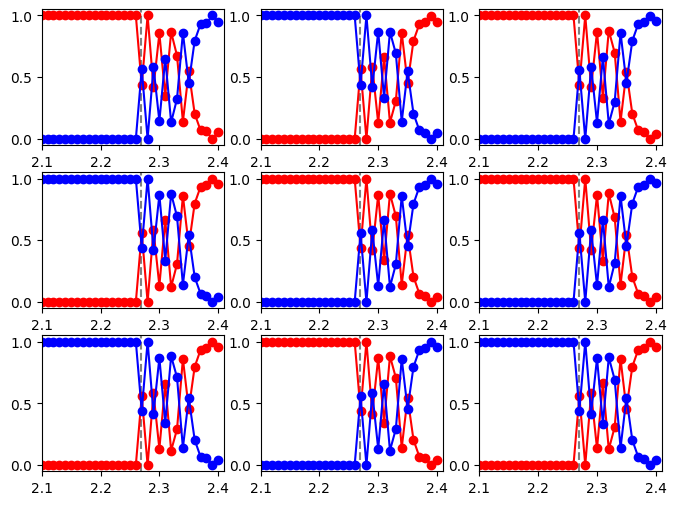

In [57]:
# flatten+PCA+kmeans
n_clusters = 2
n_components_redution_list = [9, 37, 91, 185, 336, 563, 895, 1384, 2167]

img_dataset_flatten = img_dataset.reshape(img_dataset.shape[0], -1)
sc = StandardScaler()
img_dataset_std = sc.fit_transform(img_dataset_flatten)

xs_list, y1s_list, y2s_list = [], [], []
for n_components_redution in n_components_redution_list:
    pca = PCA(n_components=n_components_redution)
    pca.fit(img_dataset_std)
    img_dataset_pca = pca.transform(img_dataset_std)
    model = KMeans(
        n_clusters=n_clusters,
        n_init=50,
        max_iter=500,
        tol=0.01,
        algorithm="elkan"
    ).fit(img_dataset_pca)

    prediction = list(model.labels_)  # クラスタのラベル
    # print(prediction)
    centers = model.cluster_centers_  # クラスタの重心
    # print(centers)
    xs, y1s, y2s = inference(prediction)
    xs_list.append(xs)
    y1s_list.append(y1s)
    y2s_list.append(y2s)
    

# 可視化
row = 3  # 行数
col = 3  # 列数

fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
for i in range(row*col):
    _r = i // col
    _c = i % col
    ax[_r,_c].axvline(x=T_cr, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr))
    ax[_r,_c].set_xlim(t_start, t_end)
    ax[_r,_c].plot(xs_list[i], y2s_list[i], label=r"$ferro$", marker="o", color="red")
    ax[_r,_c].plot(xs_list[i], y1s_list[i], label=r"$para$", marker="o", color="blue")
    # ax[_r,_c].legend()
    # ax[_r,_c].set_xlabel(r"$T$")
    # ax[_r,_c].set_ylabel(r"Probability")

In [55]:
# CNN+kmeans